In [29]:
import pandas as pd
import mariadb
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import *
import numpy as np
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import catboost

conn  = mariadb.connect(
    user='team3', 
    password='dbdb', 
    database='team3db', 
    host='localhost',
    port=3306
)

# 위 커넥션 정보와 동일하게 입력
engine = create_engine("mysql://{user}:{pw}@{host}/{db}".format(user='team3', pw='dbdb',host='localhost', db='team3db'))

In [30]:
train = pd.read_sql_query('SELECT * FROM train_UL',engine,index_col='index')
train.reset_index(inplace=True,drop=True)
train.drop(columns=['SAMPLE_ID','ID','ARI_PO','V_WIND'],inplace=True)
train

,ARI_CO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,Container,30.881018,2018-12-17 21:29,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,-0.527582,27.637513,2.014493,5,0.002615,3.450000
1,IN,Bulk,0.000000,2014-09-23 6:59,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,2.244962,28.263135,3.102933,12,0.000217,0.000000
2,CN,Container,0.000000,2015-02-03 22:00,50.0,12,146000,30.0,10.0,115250,370.0,FNPK22,Malta,-1.050854,17.651842,3.210685,6,0.001614,0.000000
3,JP,Container,0.000000,2020-01-17 4:02,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.180000,6.700000,2.629350,13,0.000356,0.000000
4,SG,Container,27.037650,2020-01-26 7:51,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.330000,25.600000,2.495953,15,0.002615,122.943750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391928,JP,Container,0.000000,2017-06-06 5:02,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",0.836331,17.033054,2.157586,14,0.000552,0.000000
391929,SG,Bulk,5.884603,2019-10-16 0:36,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,-0.660000,27.300000,1.253491,8,0.002615,122.943750
391930,US,Bulk,64.231480,2021-03-23 22:35,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,-3.440000,21.100000,4.766257,18,0.000155,41.482222
391931,TW,Container,9.448179,2015-01-08 7:15,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,-0.996649,25.702965,2.987039,15,0.000990,7.485278


In [31]:
test = pd.read_sql_query('SELECT * FROM test',engine, index_col='index')
test.reset_index(drop=True,inplace=True)
test

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE
0,TEST_000000,SG,GIW5,Container,1.826589,2020-06-18 11:58,K322654,50.0,18,117000,30.0,20.0,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615
1,TEST_000001,CN,WEY7,Cargo,25.399386,2021-05-26 22:20,E376681,10.0,13,3810,10.0,10.0,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028
2,TEST_000002,CN,NGG6,Container,111.079467,2019-12-16 0:09,F811111,20.0,26,10900,10.0,10.0,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743
3,TEST_000003,CA,FFM2,Bulk,9.175258,2015-11-16 5:30,A737561,30.0,9,55800,20.0,10.0,31500,190.0,MASW32,Panama,NaN,NaN,NaN,NaN,2,0.000182
4,TEST_000004,JP,QYY1,Container,0.000000,2018-10-24 1:11,A827175,30.0,19,39800,20.0,10.0,33000,220.0,SIEL54,Liberia,NaN,NaN,NaN,NaN,10,0.000552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220486,TEST_220486,BR,TMW2,Bulk,21.712733,2017-04-04 15:53,E731427,60.0,15,298000,30.0,20.0,151000,330.0,UWHE18,Japan,NaN,NaN,NaN,NaN,13,0.000080
220487,TEST_220487,CA,GRQ5,Bulk,4.870490,2016-08-22 16:22,Q434522,30.0,9,80500,20.0,10.0,42700,220.0,BBXV46,Liberia,NaN,NaN,NaN,NaN,13,0.000039
220488,TEST_220488,JP,VYJ1,Tanker,17.068286,2022-07-10 14:53,U148516,10.0,14,1200,0.0,0.0,500,60.0,DYUA26,Japan,-2.87,1.22,27.4,2.405268,23,0.000264
220489,TEST_220489,CN,QQW1,Cargo,0.000000,2020-12-28 14:38,C235264,10.0,27,3420,10.0,0.0,2000,80.0,VKVS56,Belize,-2.65,-0.64,8.2,2.199039,22,0.000595


In [32]:
test.isnull().sum()

SAMPLE_ID                 0
ARI_CO                    0
ARI_PO                    0
SHIP_TYPE_CATEGORY        0
DIST                      0
ATA                       0
ID                        0
BREADTH                   0
BUILT                     0
DEADWEIGHT                0
DEPTH                     0
DRAUGHT                   0
GT                        0
LENGTH                    0
SHIPMANAGER               0
FLAG                      0
U_WIND                91725
V_WIND                91725
AIR_TEMPERATURE       92246
BN                    91725
ATA_LT                    0
PORT_SIZE                 0
dtype: int64

In [33]:
test_port = test.groupby('ARI_PO')['U_WIND'].mean().to_dict()

for port, mean_temp in test_port.items():
    test.loc[test['ARI_PO'] == port, 'U_WIND'] = test.loc[test['ARI_PO'] == port, 'U_WIND'].fillna(mean_temp)
    

test['U_WIND'].isnull().sum()


5

In [34]:
test_port = test.groupby('ARI_PO')['AIR_TEMPERATURE'].mean().to_dict()

for port, mean_temp in test_port.items():
    test.loc[test['ARI_PO'] == port, 'AIR_TEMPERATURE'] = test.loc[test['ARI_PO'] == port, 'AIR_TEMPERATURE'].fillna(mean_temp)
    

test['AIR_TEMPERATURE'].isnull().sum()


5

In [35]:
test_port = test.groupby('ARI_PO')['BN'].mean().to_dict()

for port, mean_temp in test_port.items():
    test.loc[test['ARI_PO'] == port, 'BN'] = test.loc[test['ARI_PO'] == port, 'BN'].fillna(mean_temp)
    

test['BN'].isnull().sum()

5

In [36]:
test.drop(columns=['SAMPLE_ID','ID','ARI_PO','V_WIND'],inplace=True)

In [37]:
test.shape

(220491, 18)

In [38]:
test.isnull().sum()

ARI_CO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                5
AIR_TEMPERATURE       5
BN                    5
ATA_LT                0
PORT_SIZE             0
dtype: int64

In [39]:
categorical_features = ['ARI_CO', 'SHIP_TYPE_CATEGORY',  'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


In [40]:
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])
train['year'] = train['ATA'].dt.year
train['weekday'] = train['ATA'].dt.weekday
test['year'] = test['ATA'].dt.year
test['weekday'] = test['ATA'].dt.weekday
train.drop(columns=['ATA','ATA_LT','BN','SHIPMANAGER'], inplace=True)
test.drop(columns=['ATA','ATA_LT','BN','SHIPMANAGER'], inplace=True)

In [41]:
X_train = train.drop(columns='CI_HOUR')
Y_train = train['CI_HOUR']

In [42]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(test)

In [43]:
test.fillna(test.mean(),inplace=True)

In [44]:
X_train = pd.DataFrame(train_scaled, columns = X_train.columns)
test = pd.DataFrame(test_scaled, columns = test.columns)

In [45]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 391933, number of used features: 15
[LightGBM] [Info] Start training from score 31.587716


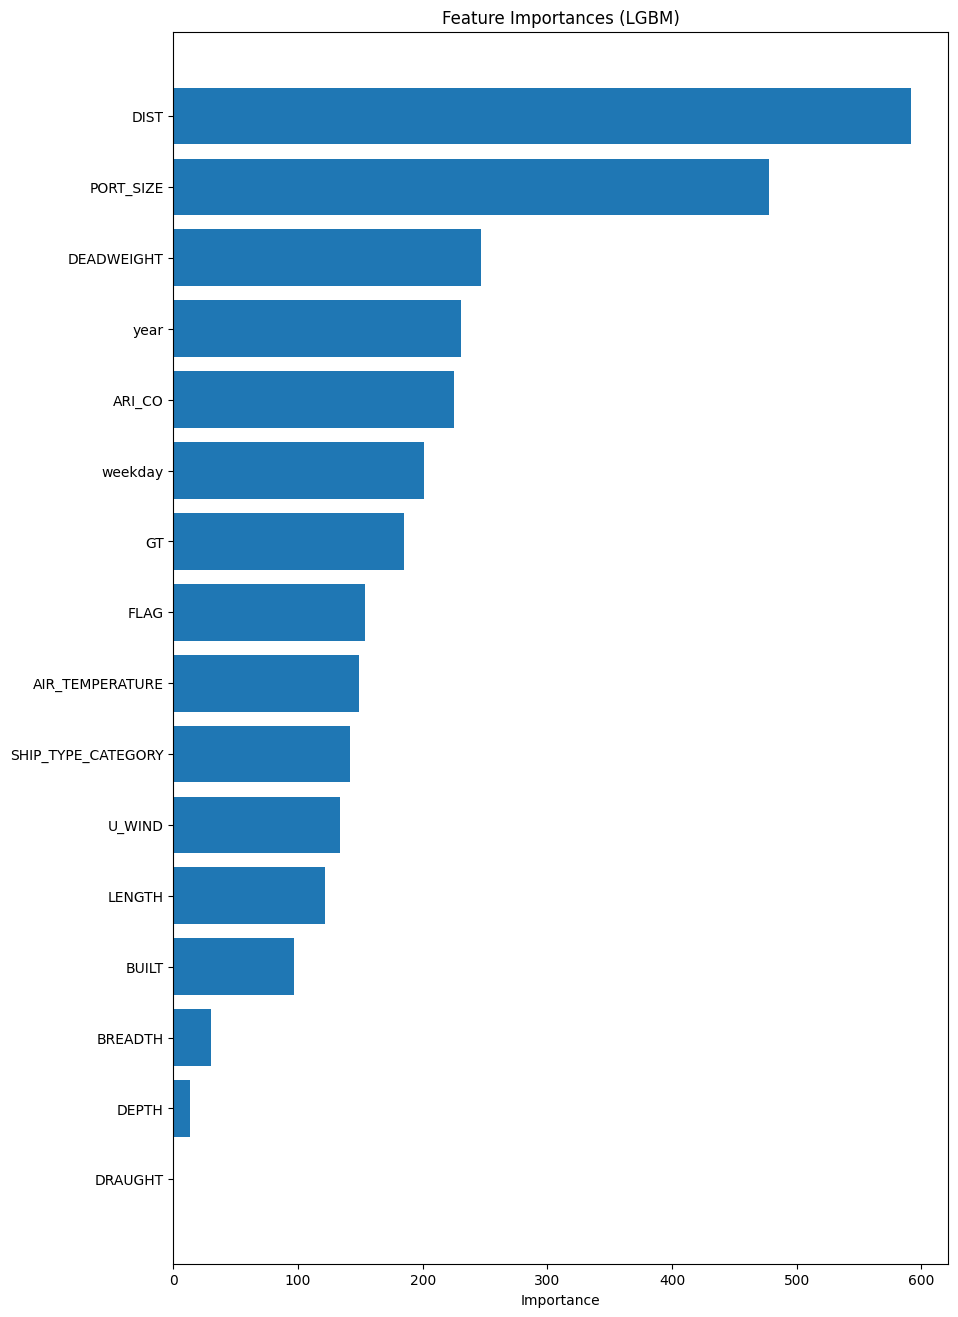

In [46]:
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, Y_train)

In [56]:
threshold = 70 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [58]:
lgbm = lgb.LGBMRegressor()


# 두 모델 모두 학습
lgbm.fit(X_train_reduced, Y_train)


# test 데이터셋에 대한 예측 수행 후 저장
lgbm_pred = lgbm.predict(X_test_reduced)
lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 391933, number of used features: 13
[LightGBM] [Info] Start training from score 31.587716
[30.08736226 24.85318442 66.38714203 ... 46.81350819  0.
 89.88310009]
